In [1]:
from matplotlib import pyplot as plt

import xarray as xr
import netCDF4 as nc
import numpy as np

import os

import datetime as dt
import pickle
import h5py

# Data loading

* Creating files containing all the runs for each model

In [2]:
# Selecting low DIV for train and high DIV for test
models = ['MIROC6', 'CanESM5', 'CESM2', 'MIROC-ES2L', 'MPI-ESM1-2-LR']
ref_period = ('1850-01-01', '2000-01-01')
coarsen_factor = 12
time_scale = 'month' # Only yearly or montly

In [3]:
import os
import numpy as np
import xarray as xr
import netCDF4 as nc
import h5py

def load_data(models, var='pr', time_scale='month', ref_period=None, path='../data/monmaxtasmax/', coarsen_factor=None, cp_anomalies=True):
    """
    Load data from NetCDF files for multiple models.
    
    Args:
        models (list): List of model names.
        var (str, optional): Variable name. Default is 'pr'.
        time_scale (str, optional): Time scale for anomaly calculation ('month' or 'year'). Default is 'month'.
        ref_period (tuple, optional): Reference period for anomaly calculation (start year, end year). Default is None.
        path (str, optional): Path to the directory containing model data. Default is '../../AnchorMultivariateAnalysis/data/ForceSMIP/Training/Amon/tas/ForceSMIP/'.
        coarsen_factor (int, optional): Coarsening factor for spatial aggregation. Default is None.
        cp_anomalies (bool, optional): If True, compute anomalies using climatology. Default is True.
        
    Returns:
        dict: Dictionary containing the loaded ensemble data.
    """
    ensemble = {}
    flag = True
    
    for model in models:
        print('## Model {}'.format(model))
        directory = path + model
        listdir = os.listdir(directory)
        data = None
        ensemble[model] = {}
        
        for i, file in enumerate(listdir, start=1):
            # print(file)
            if i > 20:
                break
            print('File {}/{}'.format(i, len(listdir)), end='\r')
            file_path = os.path.join(directory, file)
            ds = xr.open_dataset(file_path)
            
            # Compute anomalies
            if time_scale == 'month':
                if cp_anomalies:
                    climatology = ds.groupby('time.month').mean(dim='time')
                    anomalies = ds.groupby('time.month') - climatology
                else:
                    anomalies = ds
            elif time_scale == 'year':
                ds_yearly = ds.resample(time='1Y').mean()
                mean_ref_period = ds_yearly.sel(time=slice(ref_period[0], ref_period[1])).mean(dim='time')
                anomalies = ds_yearly - mean_ref_period
            
            # Apply coarsening if specified
            if coarsen_factor is not None:
                anomalies = anomalies.coarsen(lat=coarsen_factor, lon=coarsen_factor, boundary='trim').mean()
            
            # Store coordinate values if first iteration
            if flag:
                if time_scale == 'year':
                    ensemble['time'] = np.unique(anomalies['time'])
                elif time_scale == 'month':
                    ensemble['time'] = anomalies['time']
                ensemble['lat'] = anomalies['lat'].values
                ensemble['lon'] = anomalies['lon'].values  
                flag = False
            
            # Append data
            if data is None:
                data = [anomalies['tasmax'].values]
            else:
                data.append(anomalies['tasmax'].values)
            
            ds.close()
        
        ensemble[model]['tasmax'] = np.array(data)
        print()
    
    return ensemble

def save_data(data, model='CanESM5', var='tas', data_path='../data/', name_adder=''):
    """
    Save ensemble data to NetCDF or HDF5 file.
    
    Args:
        data (dict): Dictionary containing ensemble data.
        model (str): Model name. Default is 'CanESM5'.
        var (str): Variable name. Default is 'tas'.
        data_path (str): Path to save the file. Default is '../data/'.
        name_adder (str): Additional name for the file. Default is ''.
        pkl (bool): If True, save as HDF5; otherwise, save as NetCDF. Default is False.
    """
    n_members = data[model]['tasmax'].shape[0]
    
    with nc.Dataset(data_path + '{}_{}'.format(model, var) + name_adder + '.nc', 'w') as f:
        f.createDimension('n_members', n_members)
        f.createDimension('time', len(data['time']))
        f.createDimension('lat', len(data['lat']))
        f.createDimension('lon', len(data['lon']))

        members_var = f.createVariable('n_members', 'i4', ('n_members',))
        time_var = f.createVariable('time', 'f8', ('time',))
        lat_var = f.createVariable('lat', 'f4', ('lat',))
        lon_var = f.createVariable('lon', 'f4', ('lon',))
        var = f.createVariable(var, 'f4', ('n_members', 'time', 'lat', 'lon'))

        members_var[:] = np.arange(n_members)
        time_var[:] = range(1716)  # Example range
        lat_var[:] = data['lat']
        lon_var[:] = data['lon']
        var[:] = data[model]['tasmax']
            


In [4]:
for model in models :
    data = load_data([model], var='monmaxtasmax')
    save_data(data, model=model, var='monmaxtasmax')

## Model MIROC6
File 20/50
## Model CanESM5
File 20/25
## Model CESM2
File 20/21
## Model MIROC-ES2L
File 20/30
## Model MPI-ESM1-2-LR
File 20/30


In [5]:
shape = data['MIROC6']['tos'].shape
data = data['MPI-ESM1-2-LR']['tos'].reshape(shape[0]*shape[1], shape[2]*shape[3])

KeyError: 'MIROC6'

In [ ]:
data_filtered = data[:,np.isnan(data)[0]==False]

In [ ]:

plt.plot(data['MIROC6']['tasmax'][0,:,0,0])

KeyError: 'MIROC6'

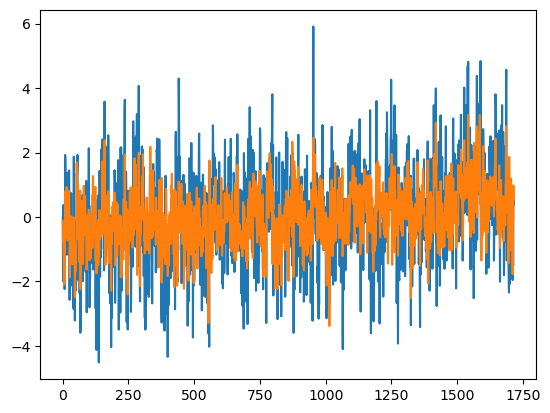

In [ ]:
i, j = 40, 30
space = data['MIROC6']['tasmax'][:,:,i,j]
response = space.mean(axis=0)
plt.plot(space[0,:])
plt.plot(response)



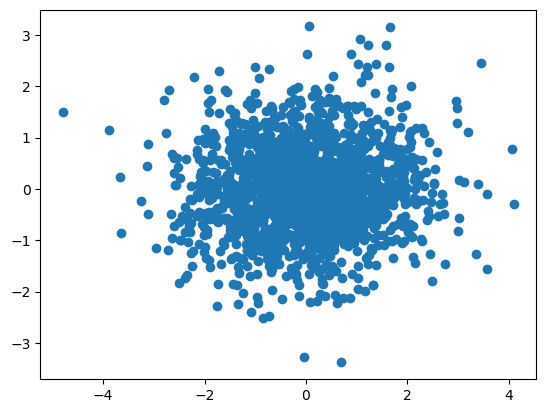

In [ ]:
plt.plot(space[0,:]-response, response, 'o')

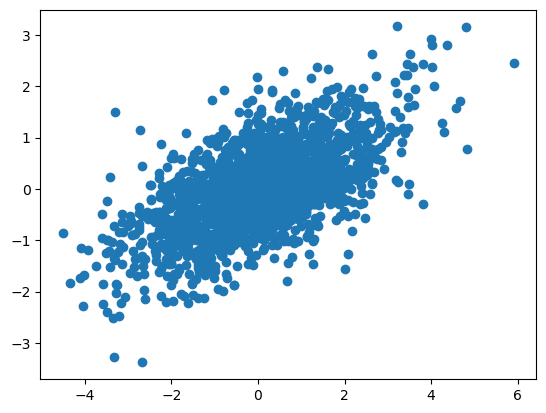

In [ ]:
plt.plot(space[0,:], response, 'o')